In [1]:
# Import packages
import os, glob, cv2, imutils, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from mtcnn.mtcnn import MTCNN

from tensorflow.keras.models import load_model

from progressbar import ProgressBar

In [2]:
# Load dataset
data_train = 'dataset/KomNet_masked2/original_sosmed/train/'
data_test = 'dataset/KomNet_masked2/original_sosmed/test/'

In [3]:
### Proses Listing Data Train
print('\n##### PROSES LISTING DATA TRAIN #####')
print('-------------------------------------')

labels_train = os.listdir(data_train)
labels_train.sort()

le = LabelEncoder()
le.fit(labels_train)

X_train_path = list()
y_train = list()

for label in labels_train:
    dir=os.path.join(data_train,label)
    n = 0
    for file in glob.glob(dir + "/*"):
        X_train_path.append(file)
        y_train.append(label)
        n+=1
    print('Listing data train pada label',label,'telah selesai. Jumlah data :', str(n))
    
y_train = le.transform(y_train)


##### PROSES LISTING DATA TRAIN #####
-------------------------------------
Listing data train pada label ade rizky wiguna telah selesai. Jumlah data : 19
Listing data train pada label arya astawa telah selesai. Jumlah data : 19
Listing data train pada label ayu sukerti telah selesai. Jumlah data : 20
Listing data train pada label caturbawa telah selesai. Jumlah data : 19
Listing data train pada label dessy telah selesai. Jumlah data : 19
Listing data train pada label dion telah selesai. Jumlah data : 19
Listing data train pada label elina telah selesai. Jumlah data : 19
Listing data train pada label evando hot simon sinaga telah selesai. Jumlah data : 19
Listing data train pada label fajar pranadi telah selesai. Jumlah data : 19
Listing data train pada label gede agus andika pratama telah selesai. Jumlah data : 20
Listing data train pada label gede ananda adi apriliawan telah selesai. Jumlah data : 19
Listing data train pada label gusti ayu nyoman sita wahana murti telah selesai. Jum

In [4]:
### Proses Listing Data Test
print('\n##### PROSES LISTING DATA TEST #####')
print('-------------------------------------')

labels_test = os.listdir(data_test)
labels_test.sort()

X_test_path = list()
y_test = list()

for label in labels_test:
    dir=os.path.join(data_test,label)
    n = 0
    for file in glob.glob(dir + "/*"):
        X_test_path.append(file)
        y_test.append(label)
        n += 1
    print('Listing data test pada label',label,'telah selesai. Jumlah data :', str(n))
    
y_test = le.transform(y_test)


##### PROSES LISTING DATA TEST #####
-------------------------------------
Listing data test pada label ade rizky wiguna telah selesai. Jumlah data : 5
Listing data test pada label arya astawa telah selesai. Jumlah data : 5
Listing data test pada label ayu sukerti telah selesai. Jumlah data : 4
Listing data test pada label caturbawa telah selesai. Jumlah data : 5
Listing data test pada label dessy telah selesai. Jumlah data : 5
Listing data test pada label dion telah selesai. Jumlah data : 5
Listing data test pada label elina telah selesai. Jumlah data : 5
Listing data test pada label evando hot simon sinaga telah selesai. Jumlah data : 5
Listing data test pada label fajar pranadi telah selesai. Jumlah data : 5
Listing data test pada label gede agus andika pratama telah selesai. Jumlah data : 4
Listing data test pada label gede ananda adi apriliawan telah selesai. Jumlah data : 5
Listing data test pada label gusti ayu nyoman sita wahana murti telah selesai. Jumlah data : 5
Listing dat

In [5]:
# Fungsi preprocessing
detector = MTCNN()

def preprocess(img):
    # Resize ukuran citra menjadi lebar 224px
    img = imutils.resize(img, width=224)
    
    # Deteksi Wajah
    faces = detector.detect_faces(img)
    w_x = 0
    for face in faces:
        w = face['box'][2]
        if w > w_x:
            theface = face
            
    # Rotasi
    (left_eye_x, left_eye_y) = theface['keypoints']['left_eye'] 
    (right_eye_x, right_eye_y) = theface['keypoints']['right_eye']
    facebox = theface['box']
    
    delta_x = right_eye_x - left_eye_x
    delta_y = right_eye_y - left_eye_y
    angle=np.arctan(delta_y/delta_x)
    angle = (angle * 180) / np.pi
    
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    
    M = cv2.getRotationMatrix2D(center, (angle), 1.0)
    
    img = cv2.warpAffine(img, M, (w, h))
    
    # Deteksi wajah pada citra rotasi
    faces = detector.detect_faces(img)
    w_x = 0
    for face in faces:
        w = face['box'][2]
        if w > w_x:
            theface = face
            
    #x_fb, y_fb, w_fb, h_fb = theface['box']
    #s_point = (x_fb, y_fb)
    #e_point = (int(x_fb+w_fb), int(y_fb+h_fb))
    #img = cv2.rectangle(img, s_point, e_point, (0, 255, 255), 2)
    
    # Cropping ROI
    x1, y1, w = theface['box'][0], theface['box'][1], theface['box'][2]
    x_n, y2 = theface['keypoints']['nose']
    x2 = x1+w
    img = img[y1:y2, x1:x2]
    
    # Resize and padding
    img = imutils.resize(img, width=160)
    h = img.shape[0]
    blank_image = np.zeros((160,160,3), np.uint8)
    blank_image[:,:] = (255,255,255)
    l_img = blank_image.copy()
    l_img[0:h, 0:160] = img.copy()    
    
    return l_img

In [6]:
# Fungsi features extraction FaceNet

# load the model
model = load_model('model/facenet_keras.h5')

model.summary()

def embeddings(imgs_path):
    embeds = list()
    labels = list()
    erors = list()
    e = 0
    pbar = ProgressBar()
    for file in pbar(imgs_path):
        label = os.path.basename(os.path.dirname(file))
        img = cv2.imread(file)
        if img.shape[2]==3: img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        try:
            img = preprocess(img)
            img = img.astype('float32')
            mean, std = img.mean(), img.std()
            img = (img-mean)/std
            samples = np.expand_dims(img, axis=0)
            yhat = model.predict(samples)
            embeds.append(yhat[0])
            labels.append(label)
        except:
            e += 1
            eror = 'Error! | ' + str(e) + ' | ' + label + ' | ' + file
            erors.append(eror)
            pass
    for eror in erors: print(eror)
    embeds = np.asarray(embeds)
    labels = np.asarray(labels)
    return (embeds, labels)

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [7]:
# Process Data Train
X_train, y_train = embeddings(X_train_path)
y_train = le.transform(y_train)

100% |########################################################################|


In [8]:
# Process Data Test
X_test, y_test = embeddings(X_test_path)
y_test = le.transform(y_test)

Error! | 1 | ade rizky wiguna | dataset/KomNet_masked2/original_sosmed/test/ade rizky wiguna\23_sosmed_ade rizky wiguna (16).jpg.jpg
Error! | 2 | ade rizky wiguna | dataset/KomNet_masked2/original_sosmed/test/ade rizky wiguna\23_sosmed_ade rizky wiguna (17).jpg.jpg
Error! | 3 | arya astawa | dataset/KomNet_masked2/original_sosmed/test/arya astawa\sosmed-1-Arya Astawa (15).jpg.jpg
Error! | 4 | caturbawa | dataset/KomNet_masked2/original_sosmed/test/caturbawa\sosmed-6- I Gusti Bagus Caturbawa (12).JPG.jpg
Error! | 5 | evando hot simon sinaga | dataset/KomNet_masked2/original_sosmed/test/evando hot simon sinaga\21_sosmed_evando hot simon sinaga (15).jpg.jpg
Error! | 6 | evando hot simon sinaga | dataset/KomNet_masked2/original_sosmed/test/evando hot simon sinaga\21_sosmed_evando hot simon sinaga (26).jpg.jpg
Error! | 7 | fajar pranadi | dataset/KomNet_masked2/original_sosmed/test/fajar pranadi\sosmed-5-Fajar Pranadi (10).jpg.jpg
Error! | 8 | fajar pranadi | dataset/KomNet_masked2/original

In [9]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(958, 128) (193, 128) (958,) (193,)


In [10]:
print(y_train)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 17 17 17

In [11]:
# Klasifikasi

import pandas as pd
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [12]:
classifiers = [
    KNeighborsClassifier(50),
    SVC(kernel='linear', probability=True),
    LogisticRegression(solver='liblinear', C=1),
    MLPClassifier(activation='relu', hidden_layer_sizes = 128, solver = 'adam')]

In [13]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, log_loss, precision_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import time

best_acc = 0
best_clf = ''

for clf in classifiers:
    #clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    start_time = time.time()   
    
    print("="*30)
    print(name)
    
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    
    train_predictions = clf.predict_proba(X_test)
    acc= accuracy_score(y_test, y_predict)

    print ('Accuracy:', acc)
    print ('F1 score:', f1_score(y_test, y_predict, average='weighted', labels=np.unique(y_predict)))
    print ('Recall:', recall_score(y_test, y_predict, average='weighted', labels=np.unique(y_predict)))
    print ('Precision:', precision_score(y_test, y_predict, average='weighted', labels=np.unique(y_predict)))
    print("--- %s seconds ---" % (time.time() - start_time))
    
    if acc>best_acc: 
        best_acc = acc
        best_clf = clf

KNeighborsClassifier
Accuracy: 0.6787564766839378
F1 score: 0.6785678835417055
Recall: 0.6858638743455497
Precision: 0.7686985789080029
--- 0.031882524490356445 seconds ---
SVC
Accuracy: 0.8549222797927462
F1 score: 0.8702175675584328
Recall: 0.8638743455497382
Precision: 0.912652705061082
--- 0.40126800537109375 seconds ---
LogisticRegression
Accuracy: 0.844559585492228
F1 score: 0.8527977779273116
Recall: 0.844559585492228
Precision: 0.8936528497409325
--- 0.6719276905059814 seconds ---
MLPClassifier
Accuracy: 0.8497409326424871
F1 score: 0.8530568452848245
Recall: 0.8497409326424871
Precision: 0.8934678016284234
--- 1.017498254776001 seconds ---


In [14]:
clf = best_clf
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

print (clf.__class__.__name__)
print ('\n clasification report:\n', classification_report(y_test, y_predict))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y_predict))

SVC

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      0.75      0.86         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       1.00      0.80      0.89         5
           7       0.60      1.00      0.75         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         2
          12       0.75      0.75      0.75         4
          13       1.00      0.80      0.89         5
          14       0.27      1.00      0.42         4
          15       0.75      0.75      0.75         4
          16       1.00      1.00      1.00         3
          17       0.83      1.00      0.91         

C:\ProgramData\Anaconda3\envs\TripletLoss\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\TripletLoss\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\TripletLoss\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

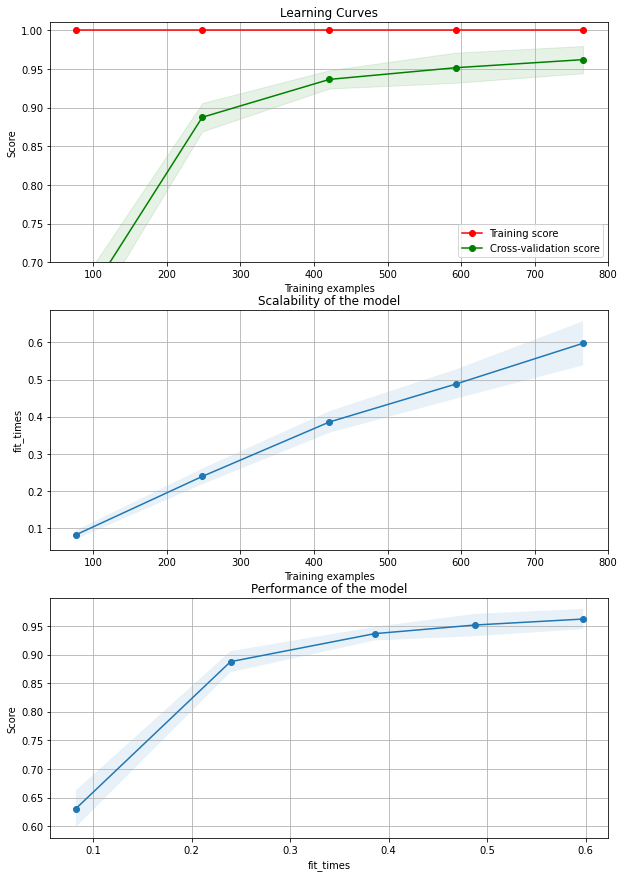

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

X, y = X_train, y_train

title = r"Learning Curves"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
estimator = best_clf
plot_learning_curve(estimator, title, X, y, axes=axes[:], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()